In [5]:
import torch
import torch.nn as nn
from scipy.stats import norm


class Norm(nn.Module):

    def __init__(self, mean, sd) -> None:
        super().__init__()
        self.mean = nn.Parameter(data = torch.tensor(float(mean)))
        self.sd = nn.Parameter(data = torch.tensor(float(sd)))
    
    def density(self, x):
        return (1/(self.sd.exp() * torch.sqrt(2 * torch.tensor(torch.pi)))) * torch.exp(-0.5 * ((x - self.mean) / self.sd.exp()) ** 2)
    
    def log_density(self, x):
        return (-0.5 * ((x - self.mean) / self.sd.exp()) ** 2) - torch.log(self.sd.exp() * torch.sqrt(2 * torch.tensor(torch.pi)))

[Parameter containing:
tensor(0., requires_grad=True), Parameter containing:
tensor(0., requires_grad=True)]


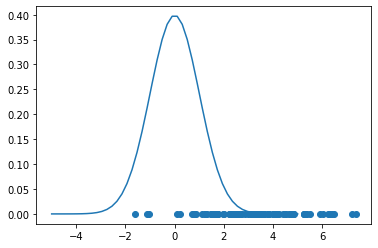

In [6]:
import matplotlib.pyplot as plt
import math

n = Norm(0, math.log(1))

xs = torch.linspace(-5, 5, 50)
with torch.no_grad():
    plt.plot(xs, [n.density(x) for x in xs])

data = norm.rvs(loc=3, scale=2, size=100, random_state = 1)
plt.scatter(data, [0]*len(data))
print(list(n.parameters()))

[Parameter containing:
tensor(3.1779, requires_grad=True), Parameter containing:
tensor(0.6000, requires_grad=True)]


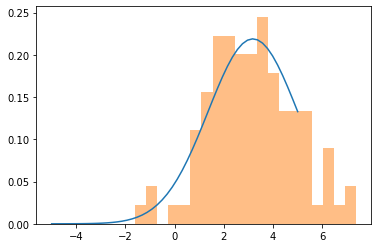

In [7]:
for i in range(100):
    l = 0
    for d in data:
        l += n.log_density(torch.tensor(d))
    l.backward()
            
    with torch.no_grad():
        for p in n.parameters():
            p += max(min(p.grad,1),-1) * 0.1 # clamp gradient
            p.grad.zero_()

print(list(n.parameters()))

with torch.no_grad():
    plt.plot(xs, [n.density(x) for x in xs])
    

plt.hist(data, density=True, bins=20, alpha=0.5);
    

In [8]:
class Trapezoidal(nn.Module):

    def __init__(self, start_end_func, slope) -> None:
        super().__init__()
        self.slope = nn.Parameter(data = torch.tensor(float(slope)))
        self.start_end_func = start_end_func
        
    def get_start_and_end(self):
        return self.start_end_func()
        
    def density(self, x):
        start, end = self.get_start_and_end()
        dist_to_mid = torch.tensor(0.0, requires_grad=True) #torch.exp(-((0.5*(end + start) - x)**2))
            
        bounded_slope = torch.tanh(self.slope) * (2 / (end - start) ** 2)
        left_height = (1 - bounded_slope * (end - start) ** 2 / 2) / (end - start)
        output = left_height + bounded_slope * (x - start)
        
    
        return torch.where((start < x) & (x <= end), output, dist_to_mid)

        
    def log_density(self, x):
        return torch.log(self.density(x))

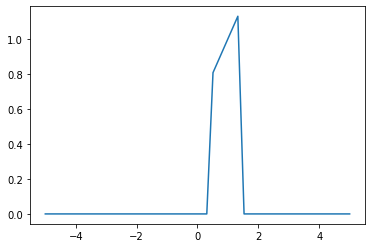

In [9]:
t = Trapezoidal(lambda: (0.5, 1.5), 0.2)

data = norm.rvs(loc=1, scale=1, size=100, random_state = 1)
with torch.no_grad():
    plt.plot(xs, t.density(xs))    
# plt.scatter(data, [0]*len(data))

tensor([-4.0000e+00, -3.6000e+00, -3.2000e+00, -2.8000e+00, -2.4000e+00,
        -2.0000e+00, -1.6000e+00, -1.2000e+00, -8.0000e-01, -4.0000e-01,
         5.9605e-08,  4.0000e-01,  8.0000e-01,  1.2000e+00,  1.6000e+00,
         2.0000e+00,  2.4000e+00,  2.8000e+00,  3.2000e+00,  3.6000e+00,
         4.0000e+00])
172.98694,176.10292,171.38652,159.4675,154.80621,156.54207,140.51672,111.65635,101.16739,98.97432,75.59805,37.80848,24.00685,15.85038,-8.22817,15.85038,

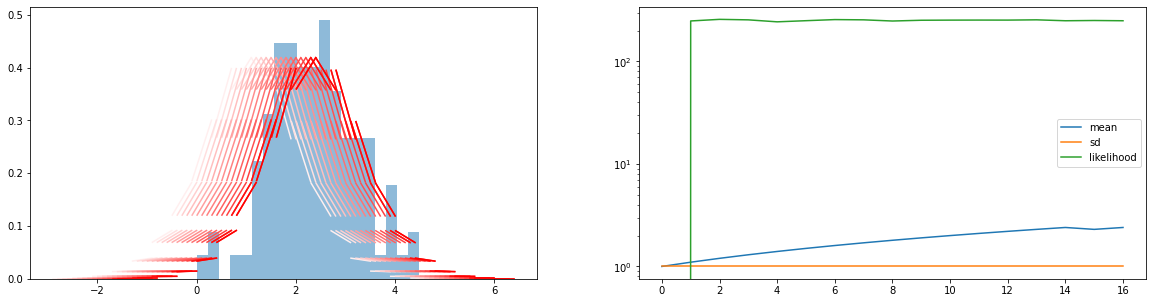

In [10]:
from IPython.display import display
from scipy.stats import norm
from matplotlib.colors import hsv_to_rgb


mean = nn.Parameter(data = torch.tensor(1.0))
sd = nn.Parameter(data = torch.tensor(math.log(1)))
points = torch.linspace(-4, 4, 20+1)
print(points)

def norm_grad(x):
    with torch.no_grad():
        return -0.2820947918e0 * math.sqrt(2) / math.exp(sd) ** 3 * (x - mean) * math.exp(-0.5e0 * (x - mean) ** 2 / math.exp(sd) ** 2)

weights = []
ts = []
ls = []

#build trapezoids
for a,b in zip(points[:-1], points[1:]):
    
    with torch.no_grad():
        left_x, right_x = a.item()*sd.exp() + mean, b.item()*sd.exp()+mean
        weights += [norm.cdf(right_x, loc=mean.item(), scale=sd.exp().item()) - norm.cdf(left_x, loc=mean.item(), scale=sd.exp().item())]

    l = lambda a=a, b=b: (a*sd.exp()+mean, b*sd.exp()+mean)

    ls += [l]
    ts += Trapezoidal(l, torch.arctanh(norm_grad(0.5*(left_x+right_x)))),
    

data = norm.rvs(loc=2.3, scale=1, size=100, random_state = 1)
xs = torch.linspace(-5, 5, 50)
param_tracking = []
param_tracking += [(mean.item(), sd.exp().item(), 0)]

fig, ax = plt.subplots(1,2, figsize=(20,5))


epochs = 16
for i in range(epochs):
    l = 0
    for t, w in zip(ts, weights): # for each trapezoid and its mixture weight
        l += (t.density(torch.tensor(data))).sum()
    
    l.backward()
    with torch.no_grad():        
        for p in [mean]:
            if p.grad is not None:
                print(round(p.grad.item(), ndigits=5), end =",")
                p += max(min(p.grad,1),-1) * 0.1 # clamp gradient
                p.grad.zero_()

    param_tracking += [(mean.item(), sd.exp().item(), l.item())]

    with torch.no_grad():
        for t, w in zip(ts, weights):
            start, end = t.get_start_and_end()
            domain = torch.linspace(start+0.01, end, 100)
            ax[0].plot(domain, w * t.density(domain), c = hsv_to_rgb((0, math.pow((i+1)/epochs, 1), 1))) 


ax[0].hist(data, density=True, bins=20, alpha=0.5)

for (p), name in zip(zip(*param_tracking), ["mean", "sd", "likelihood"]):
    ax[1].plot(p, label = name)
ax[1].set_yscale("log")

ax[1].legend();

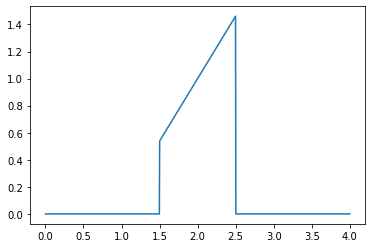

In [13]:
from torch.autograd import Function

class Trapezoid(Function):

    @staticmethod
    def forward(ctx, start, end, slope, x):
        ctx.save_for_backward(start, end, slope, x)
        
        bounded_slope = torch.tanh(slope) * (2 / (end - start) ** 2)
        left_height = (1 - bounded_slope * (end - start) ** 2 / 2) / (end - start)
        output = left_height + bounded_slope * (x - start)

        return torch.where((start < x) & (x <= end), output, torch.zeros_like(x))

    @staticmethod
    def backward(ctx, grad_output):
        start, end, slope, x = ctx.saved_tensors
        # print(start,end,slope,x)
        grad_start = torch.where((start < x) & (x <= end), -slope * grad_output, 1e-5 * torch.sign(x - 0.5*(start+end)) * grad_output)
        grad_end = torch.where((start < x) & (x <= end), -slope * grad_output, 1e-5 * torch.sign(x - 0.5*(start+end)) * grad_output)
        grad_slope = torch.where((start < x) & (x <= end), (x - start) * grad_output, torch.zeros_like(grad_output))
        grad_x = torch.where((start < x) & (x <= end), slope * grad_output, torch.sign(0.5*(start+end)-x) * grad_output)
        return grad_start, grad_end, grad_slope, grad_x
    

xs = torch.linspace(0, 4, 1000)
plt.plot(xs, Trapezoid.apply(1.5, 2.5, torch.tensor(0.5), xs))

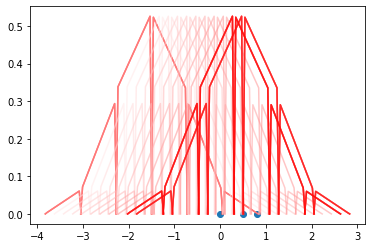

In [12]:
point = torch.tensor([2,2.5,2.8]) -2

mean = nn.Parameter(data = torch.tensor(-1.5))
sd = torch.tensor(math.log(0.8))

def norm_grad(x):
    with torch.no_grad():
        t1 = math.sqrt(2)
        t2 = math.sqrt(math.pi)
        t5 = sd.exp() ** 2
        t8 = mean - x
        t10 = t8 ** 2
        t14 = math.exp(-0.1e1 / t5 * t10 / 2)
        return t14 * t8 / t5 / sd.exp() * t1 / t2 / 2


ws = []
fs = []
ls = []

#build trapezoids
slope = torch.tensor(0.1)
f = Trapezoid.apply

xs = torch.linspace(-4, 4, 1000)
# plt.plot(xs, norm.pdf(xs, loc=mean.item(), scale=sd.exp().item()))

points = torch.linspace(-2.9, 2.9, 6+1)

for a,b in zip(points[:-1], points[1:]):
        start = mean + sd.exp()*a
        end = mean + sd.exp()*b
        with torch.no_grad():
            ws += [norm.cdf(end, loc=mean.item(), scale=sd.exp().item()) - norm.cdf(start, loc=mean.item(), scale=sd.exp().item())]
            slope = torch.arctanh((1/ws[-1])*norm_grad(0.5*(start+end)) /  (2 / (end - start) ** 2))
        
        with torch.no_grad():
            domain = torch.linspace(start+0.00, end.item()+0.01, 20)
            plt.plot(domain, ws[-1] * f(start,end, slope, domain), c=hsv_to_rgb((1, 1, 1)))
        
        # l += f(start, end, slope, point).sum() * ws[-1]


epochs = 20
for i in range(epochs):
    l = 0
    for a,b in zip(points[:-1], points[1:]):
        start = mean + sd.exp()*a
        end = mean + sd.exp()*b
        with torch.no_grad():
            ws += [norm.cdf(end, loc=mean.item(), scale=sd.exp().item()) - norm.cdf(start, loc=mean.item(), scale=sd.exp().item())]
            slope = torch.arctanh((1/ws[-1])*norm_grad(0.5*(start+end)) /  (2 / (end - start) ** 2))
        
        with torch.no_grad():
            domain = torch.linspace(start+0.00, end.item()+0.01, 20)
            plt.plot(domain, ws[-1] * f(start,end, slope, domain), c=hsv_to_rgb((1, (i+1)/epochs, 1)), alpha = 0.5)
        
        l += f(start, end, slope, point).sum() * ws[-1]

    l.sum().backward()
    with torch.no_grad():
        mean += mean.grad.sign() * 0.2
        mean.grad.zero_()


plt.scatter(point, [0]*len(point))